# IMEX-RB: A Fast and Stable Time Integration Method


In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np
from src.imexrb import imexrb
from src.euler import backward_euler, forward_euler
from src.problemsPDE import AdvDiff2D
import utils.mpl_pubstyle
from utils.errors import compute_errors
from utils.helpers import *

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL.PngImagePlugin').setLevel(logging.WARNING)

15:20:01 - matplotlib - DEBUG - matplotlib data path: /home/francesco/anaconda3/envs/imexrb-FD/lib/python3.13/site-packages/matplotlib/mpl-data
15:20:01 - matplotlib - DEBUG - CONFIGDIR=/home/francesco/.config/matplotlib
15:20:01 - matplotlib - DEBUG - interactive is False
15:20:01 - matplotlib - DEBUG - platform is linux


## Solving a 2D Advection-Diffusion equation

The advection–diffusion problem is defined over the spatial domain $\Omega = [0,2] \times [0,2]$ and the time interval $[0,1]$:

$$
\begin{cases}
\dfrac{\partial u}{\partial t} + c_x \dfrac{\partial u}{\partial x} + c_y \dfrac{\partial u}{\partial y} - \mu \Delta u = f(\mathbf{x},t),
  & \mathbf{x} \in \Omega,\; t > 0, \\[1em]
u(\mathbf{x}, 0) = u_0(\mathbf{x}), 
  & \mathbf{x} \in \Omega, \\[0.5em]
u(\mathbf{x}, t) = g(\mathbf{x}), 
  & \mathbf{x} \in \partial \Omega,
\end{cases}
$$

where $\mathbf{x} = [x, y]^{T}$. We choose the advection and diffusion parameters as
$$
\mathbf{c} = [c_x, c_y] = [0.5, 0.25], 
\quad
\mu = 0.005,
$$

while the forcing term is given by

$$
f(\mathbf{x}, t) = \frac{\mu U}{(\sigma^2 + \mu t)^2} \ \left( 4 (\sigma^2 + \mu t) - 3 \Vert \mathbf{x} - \mathbf{x_0} - \mathbf{c} t \Vert_2^2 \right) \ \exp\left( - \frac{\Vert \mathbf{x} - \mathbf{x_0} - \mathbf{c} t \Vert_2^2}{\sigma^2 + \mu t} \right)~,
$$

where we set $\mathbf{x_0} = [0.25, 0.25]$, $\sigma=0.25$ and $U = 0.25$.

The analytical solution writes as follows:

$$
u_{\mathrm{ex}}(x, y, t)
= U
  \exp\!\left(
    -\frac{\Vert \mathbf{x} - \mathbf{x_0} - \mathbf{c} t \Vert_2^2}{\sigma^2 + \mu t}
  \right)~;
$$

we note that $\sigma > 0$ regulates the amplitude of the peak in the initial condition and $U>0$ is the peak solution value at $t=0$. The initial and Dirichlet data are inferred from the exact solution.

---

We can now integrate in time, to show the performance of IMEX-RB compared to classic 1st order integration schemes, i.e. Backward/Forward Euler.

In [3]:
problem_name = "AdvDiff2D"

mu = 0.005
sigma = 0.25

Lx = 1
Ly = 1

vx = 0.5
vy = 0.25

t0 = 0.0
tf = 1.0
tspan = [t0, tf]

Nx = 101
Ny = 101

# Define the problem object, fetch the initial condition evaluated at the grid points
problem = AdvDiff2D(Nx, Ny, Lx, Ly, mu=mu, sigma=sigma, vx=vx, vy=vy, center=[0.25, 0.25])
u0 = problem.initial_condition()

We now integrate over time, using different schemes. First of all, we define some parameters for the time integration

In [4]:
# Define number of timesteps
Nt = 100
# Define epsilon for absolute stability condition
# We employ the estimate 1/cond(A)
epsilon = 1.0 / cond_sparse(problem.A)
# Define max dimension of subspace before subiterations
maxsize = 10 
# Define max allowed enlargement during subiterations
maxsubiter = 100

Let us have a look at the selected parameters characterizing the IMEX-RB integration

In [5]:
print(f"The subspace has an initial dim = {maxsize}, and such dim can grow up to {maxsize + maxsubiter - 1}"
      f"\nThe full order problem has dim = {problem.Nh}")
print(f"The selected \\varepsilon is {epsilon:.4e}")
print(f"Local x-Peclet number is approx {vx * tf / (2 * mu * Nt)}")

The subspace has an initial dim = 10, and such dim can grow up to 109
The full order problem has dim = 10201
The selected \varepsilon is 2.1060e-03
Local x-Peclet number is approx 0.5


We compute the number of timesteps making forward Euler stable, for comparison with the other schemes

In [6]:
Nt_FE = compute_steps_stability_FE(problem, tspan)
print(f"Forward Euler minimal steps number: {Nt_FE}")

Forward Euler minimal steps number: 195


### Time integration

In [7]:
# First, IMEX-RB
uIMEX, tvec, subiter = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
# Backward Euler
uBE, tvec = backward_euler(problem, u0, tspan, Nt)
# Forward Euler may throw errors if unstable
# uFE, tvecFE, *_ = forward_euler(problem, u0, tspan, Nt_FE)

15:20:19 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total):0/100


In [8]:
# Compute error as average over time
errIMEXavg = compute_errors(uIMEX, tvec, problem, mode='l2')
errBEavg = compute_errors(uBE, tvec, problem, mode='l2')
print(f"Relative errors: IMEX-RB: {errIMEXavg:.4e}; Backward Euler: {errBEavg:.4e}")

Relative errors: IMEX-RB: 1.6892e-02; Backward Euler: 1.6634e-02


### Plot errors and inner iterations
We plot the errors over time for the previously chosen parameters

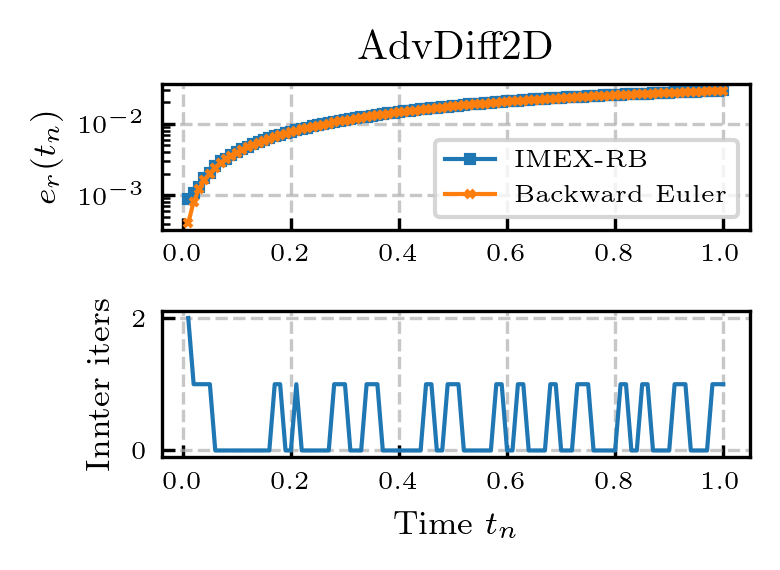

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.subplot(2,1,1)
# Compute relative errors over time 
errIMEX = compute_errors(uIMEX, tvec, problem)
errBE = compute_errors(uBE, tvec, problem)

# Plot the errors
plt.semilogy(tvec[1:], errIMEX, label="IMEX-RB", marker='s')
plt.semilogy(tvec[1:], errBE, label="Backward Euler", marker='x', alpha=1)
# plt.semilogy(tvecFE[1:], errFE, label="Forward Euler (stable)", marker='^')

plt.ylabel(r"$e_r(t_n)$")
plt.title(f"{problem_name}")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(tvec[1:], subiter, label="iter")
plt.xlabel(r"Time $t_n$")
plt.ylabel(r"Innter iters")
# plt.axhline(maxsubiter, linestyle=":", color="k", label=r"max subiters")
# plt.legend()

# Show the plot
plt.show()

### Plot the animation of the solution


Using a 3D plot

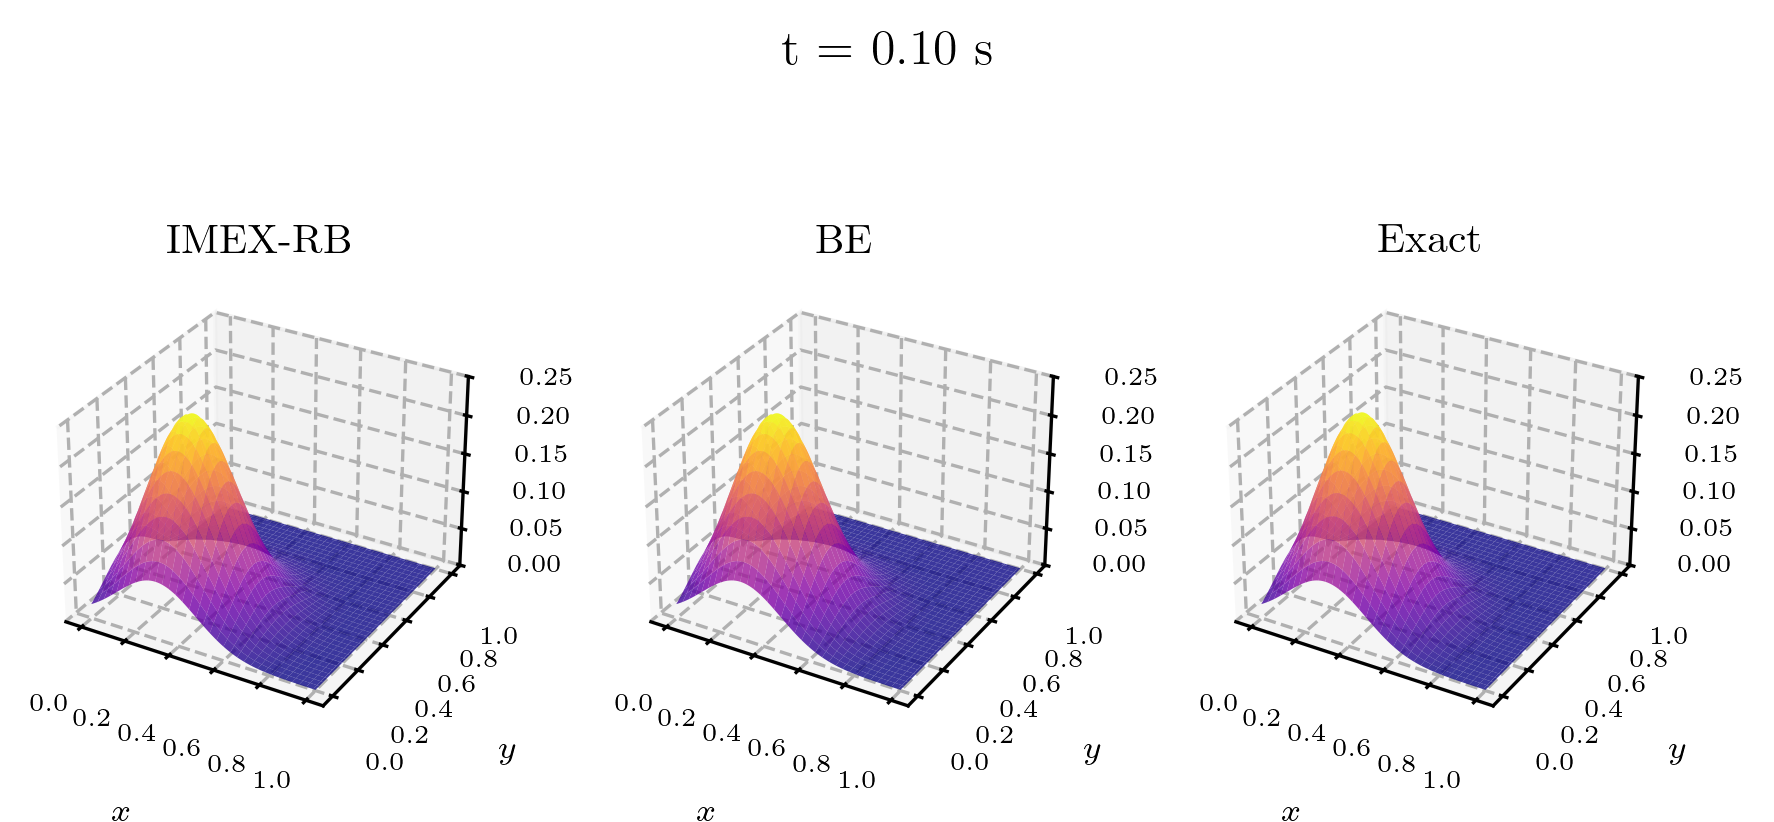

KeyboardInterrupt: 

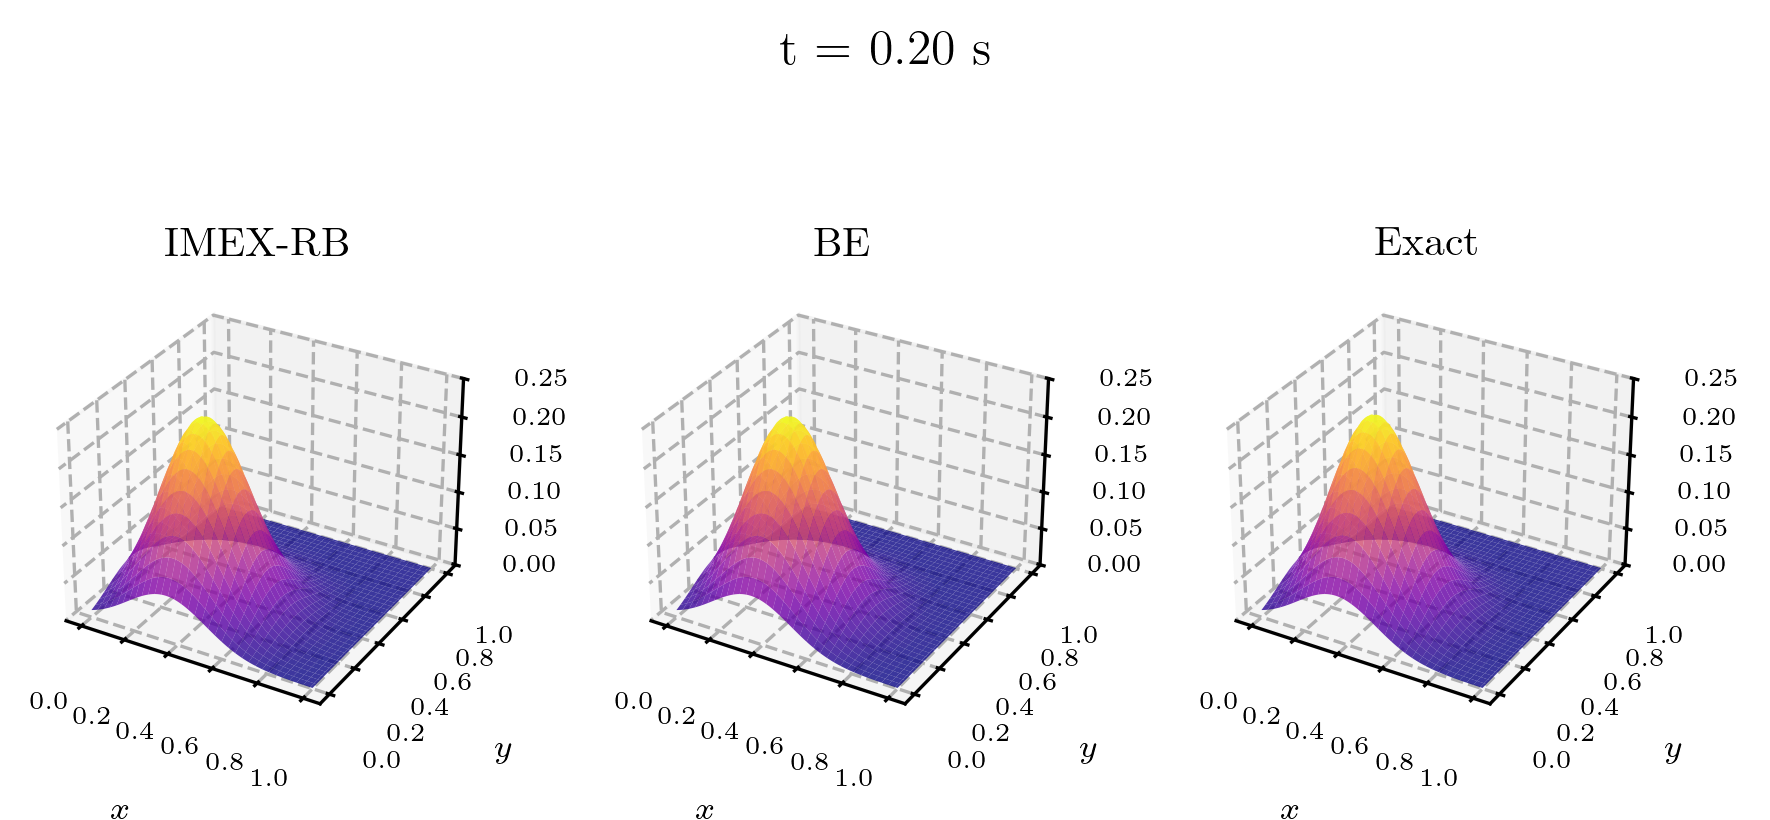

In [ ]:
%matplotlib ipympl
from IPython import display
import time
from mpl_toolkits.mplot3d import Axes3D

X, Y = problem.coords
Nx, Ny = problem.shape

u_exact = lambda t : problem.exact_solution(t, X, Y).reshape((Nx, Ny))

zmin = min(uIMEX.min(), uBE.min())
zmax = max(uIMEX.max(), uBE.max())

# Setup figure with two 3D subplots
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
hdisplay = display.display("", display_id=True)

for ax, title in [(ax1, "IMEX-RB"), (ax2, "BE"), (ax3, "Exact")]:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$u$")
    ax.set_zlim(zmin, zmax)
    ax.set_title(title)

surf1 = ax1.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="plasma", alpha=0.8)
surf2 = ax2.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="plasma", alpha=0.8)
surf3 = ax3.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="plasma", alpha=0.8)

for n, t in enumerate(tvec[::10]):
    surf1.remove()
    surf2.remove()
    surf3.remove()
    
    Z1 = uIMEX[:, 10*n].reshape((Nx, Ny))
    Z2 = uBE[:,   10*n].reshape((Nx, Ny))
    Z3 = u_exact(t)
    
    # re‐plot
    surf1 = ax1.plot_surface(X, Y, Z1, cmap="plasma", alpha=0.8)
    surf2 = ax2.plot_surface(X, Y, Z2, cmap="plasma", alpha=0.8)
    surf3 = ax3.plot_surface(X, Y, Z3, cmap="plasma", alpha=0.8)

    plt.suptitle(f"t = {t:.2f} s")
    
    hdisplay.update(fig)
    # time.sleep(0.001)

plt.close(fig)


Using a contour plot

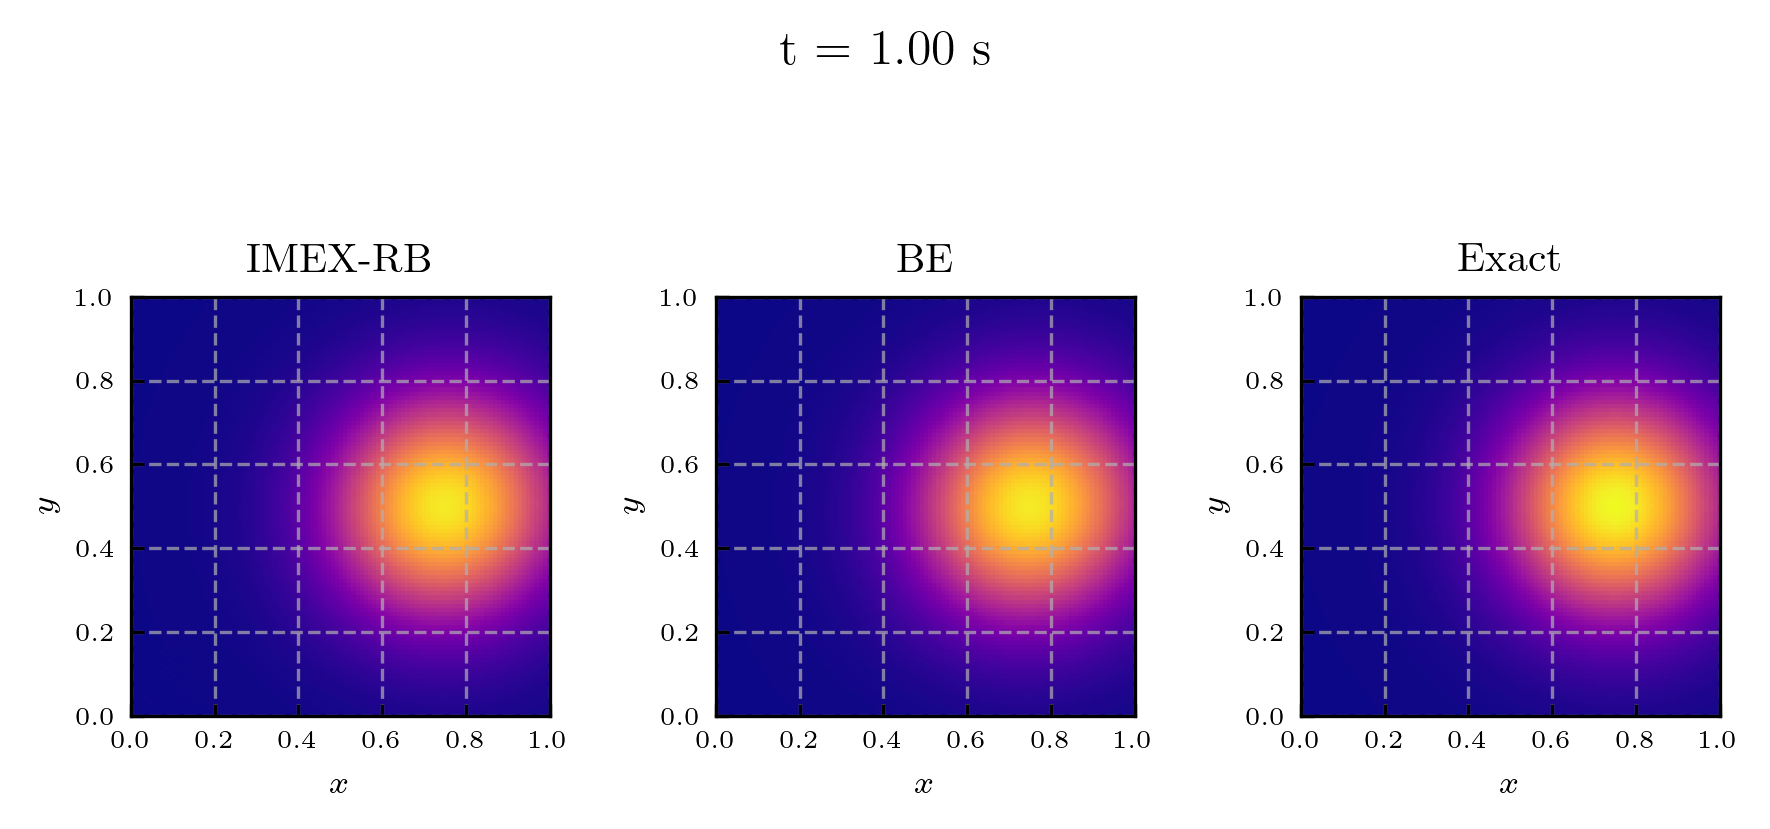

In [ ]:
X, Y = problem.coords
Nx, Ny = problem.shape

zmin = min(uIMEX.min(), uBE.min())
zmax = max(uIMEX.max(), uBE.max())

u_exact = lambda t : problem.exact_solution(t, X, Y).reshape((Nx, Ny))

fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
hdisplay = display.display("", display_id=True)

for ax, title in [(ax1, "IMEX-RB"), (ax2, "BE"), (ax3, "Exact")]:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(title)

for n, t in enumerate(tvec[::10]):

    Z1 = uIMEX[:, 10*n].reshape((Nx, Ny))
    Z2 = uBE[:,   10*n].reshape((Nx, Ny))
    Z3 = u_exact(t)
    
    im1 = ax1.imshow(Z1, extent=[0, Lx, 0, Ly], vmin=zmin, vmax=zmax,
                     origin='lower', cmap='plasma', aspect='equal')
    im2 = ax2.imshow(Z2, extent=[0, Lx, 0, Ly], vmin=zmin, vmax=zmax,
                     origin='lower', cmap='plasma', aspect='equal')
    im3 = ax3.imshow(Z3, extent=[0, Lx, 0, Ly], vmin=zmin, vmax=zmax,
                     origin='lower', cmap='plasma', aspect='equal')
    
    plt.suptitle(f"t = {t:.2f} s")
    
    hdisplay.update(fig)
    # time.sleep(0.001)

plt.tight_layout()
plt.close(fig)

Plotting some snapshots (see Figure 1 in the article)

/tmp/ipykernel_84521/4190957677.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('advDiff2D_sol.pdf')
/home/francesco/anaconda3/envs/imexrb-FD/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


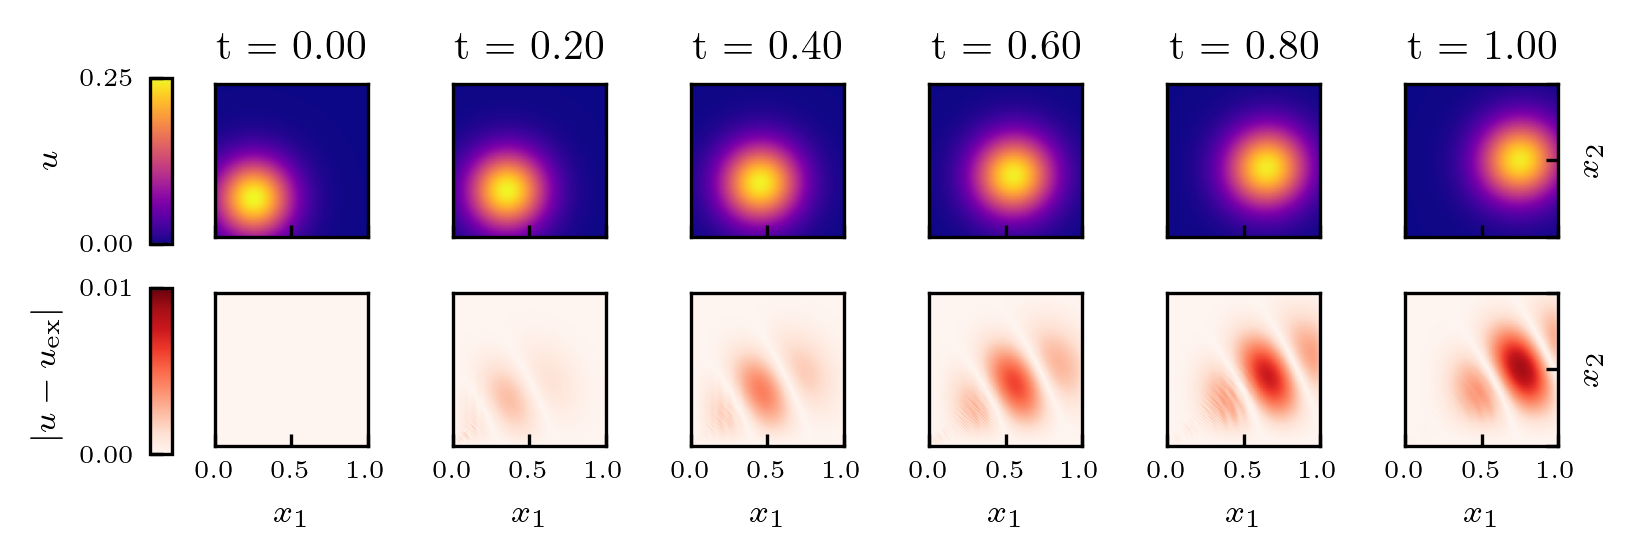

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Kt = 6

X, Y = problem.coords
Nx, Ny = problem.shape

zmin = uIMEX.min()
zmax = uIMEX.max()

u_exact = lambda t : problem.exact_solution(t, X, Y).reshape((Nx, Ny))

# Setup figure with two 3D subplots
fig, axs = plt.subplots(2, Kt, figsize=(5, 2), sharex=True, sharey=True)
fig.subplots_adjust(left=0.15, wspace=0.2, hspace=0.3)

mappables = [[], []]

K = int(Nt / (Kt-1))
for n, t in enumerate(tvec[::K]):

    Z1 = uIMEX[:, K*n].reshape((Nx, Ny))
    Z2 = np.abs(Z1 - u_exact(t))
    
    im1 = axs[0, n].imshow(Z1, extent=[0, Lx, 0, Ly], vmin=zmin, vmax=zmax,
                           origin='lower', cmap='plasma', aspect='equal')
    im2 = axs[1, n].imshow(Z2, extent=[0, Lx, 0, Ly], vmin=0, vmax=0.01,
                           origin='lower', cmap='Reds', aspect='equal')

    mappables[0].append(im1)
    mappables[1].append(im2)

    axs[1, n].set_xticks([0, 0.5, 1])
    axs[1, n].set_xlabel("$x_1$")
    
    for ax in axs[:, n]:
        ax.tick_params(labelleft=False, left=False)
        ax.grid(False)
        if n == Kt - 1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.set_yticks([0, 0.5, 1])
            ax.set_ylabel("$x_2$")

    axs[0, n].set_title(f"t = {t:.2f}")

for i in range(2):

    pos = axs[i, 0].get_position()

    if i == 0:
        cax = fig.add_axes([0, pos.y0 - 0.02, 0.015, pos.y1 - pos.y0 + 0.01])
    else:
        cax = fig.add_axes([0, pos.y0 + 0.065, 0.015, pos.y1 - pos.y0 + 0.01])
        
    if i == 0:
        cbar = fig.colorbar(mappables[i][0], cax=cax, orientation='vertical')
        cax.yaxis.set_ticks([0, 0.25])
        cbar.set_label(r'$u$')
    else:
        cbar = fig.colorbar(mappables[i][1], cax=cax, orientation='vertical')
        cax.yaxis.set_ticks([0, 0.01])
        cbar.set_label(r'$|u - u_{\mathrm{{ex}}}|$')

    cax.yaxis.set_ticks_position('left')
    cax.yaxis.set_label_position('left')


plt.savefig('advDiff2D_sol.pdf')

Go back to `matplotlib inline` (after animation)

In [13]:
plt.close('all')
from IPython.display import clear_output
clear_output(wait=True)
%matplotlib inline